# ANALYTICS VIDHYA - THE ULTIMATE STUDENT HUNT

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st

from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

/Users/Apple/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
train = pd.read_csv('train.csv', parse_dates=['Date'], dayfirst=True)
test = pd.read_csv('test.csv', parse_dates=['Date'], dayfirst=True)
ss = pd.read_csv('samplesubmission.csv')

After analyzing the data I just broke the date into three parts month, day and year. Since the data was a timeseries data I was expecting a strong relation between footfall and year but luckily there was no such relation. There was a strong relation between the month and footfall.

In [3]:
train['Date'] = pd.to_datetime(train['Date'], format='%y-%m-%d')
test['Date'] = pd.to_datetime(test['Date'], format='%y-%m-%d')

train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Week'] = train['Date'].dt.week
train['Day_Of_Week'] = train['Date'].dt.dayofweek
train['Day'] = train['Date'].dt.day

test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Week'] = test['Date'].dt.week
test['Day_Of_Week'] = test['Date'].dt.dayofweek
test['Day'] = test['Date'].dt.day

In [13]:
train['Day_Of_Year'] = train['Date'].dt.dayofyear
test['Day_Of_Year'] = test['Date'].dt.dayofyear

In [15]:
col = [u'Direction_Of_Wind',
       u'Average_Breeze_Speed', u'Max_Breeze_Speed', u'Min_Breeze_Speed',
       u'Var1', u'Average_Atmospheric_Pressure', u'Max_Atmospheric_Pressure',
       u'Min_Atmospheric_Pressure', u'Min_Ambient_Pollution',
       u'Max_Ambient_Pollution', u'Average_Moisture_In_Park',
       u'Max_Moisture_In_Park', u'Min_Moisture_In_Park']

The data contained several missing values and filling it with appropriate values was one of the most important tasks to get accurate predictions. Few of the park ids (15,20 and 23) had no values for atmospheric pressure, few had no values for pollution and pressure, few had no value for var1. Initially, we decided to break the big dataset into 5 sets and analyze it separately but we were not able to improve our accuracy with this technique (I have uploaded the file in which we tried this on my github repo for those who are interested). The best score we got was 118 on the leaderboard. So we decided to switch back to the entire dataset and do some smart imputations. We imputed the missing values with the median of that day of that year. Though after the competition we were told by one of my friends who finished 4th that the technique we used was not smart enough. He imputed the missing values with the median of that day of that year but he did one smart thing, he separated the ids according to their location id first and then did this imputation! 


In [2]:
for y in train['Year'].unique():
    print y
    for d in train['Day_Of_Year'].unique():
        for c in col:
            train[c][(train['Year']==y) & (train['Day_Of_Year']==d)] = train[c][(train['Year']==y) & (train['Day_Of_Year']==d)].fillna(train[c][(train['Year']==y) & (train['Day_Of_Year']==d)].mean())

In [3]:
for y in test['Year'].unique():
    print y
    for d in test['Day_Of_Year'].unique():
        for c in col:
            test[c][(test['Year']==y) & (test['Day_Of_Year']==d)] = test[c][(test['Year']==y) & (test['Day_Of_Year']==d)].fillna(test[c][(test['Year']==y) & (test['Day_Of_Year']==d)].mean())

We deleted the data of park id 19 because there were no entries for that park after the year 1998. Also, we deleted the data of 1991 for park id 17 because it was getting unexpectedly high footfall during that time.

In [19]:
train = train[~((train['Park_ID']==17)&(train['Year']==1991))]
train = train[~(train['Park_ID']==19)]

After some brainstorming, we decided to break the direction of wind into two components by taking its cosine and sine components. This we did because if we carefully look at the trend of data and think logically we will see if there is some increase in footfall when the wind blows at 2 degrees then there should be increase for 359 degrees also but how my model will understand this so we decided to break it into two components. Also, we created two new features by multiplying average breeze speed with cosine component and sine component.

In [41]:
train['Direction_x'] = 0
train['Direction_y'] = 0

train['Speed_x'] = 0
train['Speed_y'] = 0

train['Direction_x'] = np.cos(np.radians(train['Direction_Of_Wind']))
train['Direction_y'] = np.sin(np.radians(train['Direction_Of_Wind']))

train['Speed_x'] = train['Average_Breeze_Speed']*train['Direction_x']
train['Speed_y'] = train['Average_Breeze_Speed']*train['Direction_y']

test['Direction_x'] = 0
test['Direction_y'] = 0

test['Speed_x'] = 0
test['Speed_y'] = 0

test['Direction_x'] = np.cos(np.radians(test['Direction_Of_Wind']))
test['Direction_y'] = np.sin(np.radians(test['Direction_Of_Wind']))

test['Speed_x'] = test['Average_Breeze_Speed']*test['Direction_x']
test['Speed_y'] = test['Average_Breeze_Speed']*test['Direction_y']

The var1 data was positively skewed so we decided to do log transformation of it.

In [189]:
train['Var2'] = np.log(1+train['Var1'])
test['Var2'] = np.log(1+test['Var1'])

For the experimental purpose, we even tried to create a relative humidity feature by dividing the average moisture park and maximum moisture park.

In [280]:
train['Relative_Humidity'] = train['Average_Moisture_In_Park']/train['Max_Moisture_In_Park']
test['Relative_Humidity'] = test['Average_Moisture_In_Park']/test['Max_Moisture_In_Park']

Another experimental feature.

In [334]:
train['new1'] = train['Average_Atmospheric_Pressure']*train['Average_Moisture_In_Park']
test['new1'] = test['Average_Atmospheric_Pressure']*test['Average_Moisture_In_Park']

In [427]:
train.to_csv('new_train.csv', index = False)
test.to_csv('new_test.csv', index = False)

After creating some graphs and analyzing data we could clearly see that the footfall distribution was bimodal, 
there was one peak at 1200 and another around 1400. So we decided to break the data into two parts by months to 
make the data unimodal.

In [484]:
t1 = train[train['Month'].isin([1,2,3,4,11,12])]
t2 = train[train['Month'].isin([5,6,7,8,9,10])]

To reduce the number of weeks such that in the later stages instead of encoding we could convert it into binary features, we binned the weeks by observing the trend in those weeks for different park ids.

In [4]:
t1['Week1'] = 0
t1['Week1'][t1['Week'].isin([1,4,53,51])] = 1
t1['Week1'][t1['Week'].isin([6,7,8,9,50,52])] = 2
t1['Week1'][t1['Week'].isin([2,3,5,10])] = 3
t1['Week1'][t1['Week'].isin([48,49,11,12,47])] = 4
t1['Week1'][t1['Week'].isin([13,14,15,45,46])] = 5
t1['Week1'][t1['Week'].isin([16,44])] = 6
t1['Week1'][t1['Week'].isin([17,18])] = 7

test['Week1'] = 0
test['Week1'][test['Week'].isin([1,4,53,51])] = 1
test['Week1'][test['Week'].isin([6,7,8,9,50,52])] = 2
test['Week1'][test['Week'].isin([2,3,5,10])] = 3
test['Week1'][test['Week'].isin([48,49,11,12,47])] = 4
test['Week1'][test['Week'].isin([13,14,15,45,46])] = 5
test['Week1'][test['Week'].isin([16,44])] = 6
test['Week1'][test['Week'].isin([17,18])] = 7

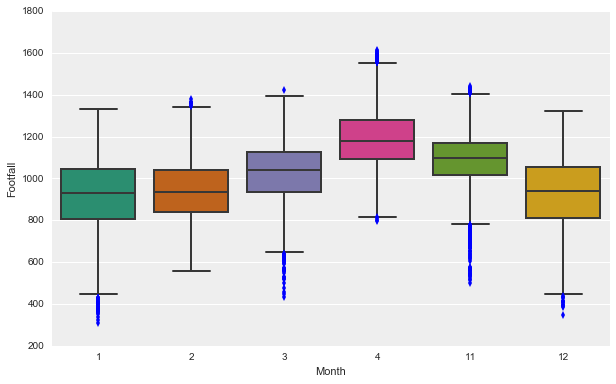

In [369]:
sns.boxplot(t1['Month'], t1['Footfall'], order = np.sort(t1['Month'].unique()))

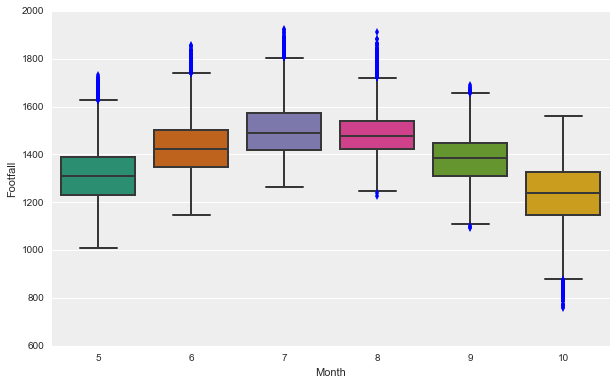

In [325]:
sns.boxplot(t2['Month'], t2['Footfall'], order = np.sort(t2['Month'].unique()))

We tried different combinations of features throughout the competition to get a better score. It is always recommended to remove highly correlated features before training the model. For selecting features, we carefully observed the feature importance of random forest and xgboost model. 

In [486]:
#Experimenting

colu = [u'Park_ID', 
        u'Max_Breeze_Speed', u'Min_Breeze_Speed',
       u'Var2', u'Max_Atmospheric_Pressure',
       u'Min_Atmospheric_Pressure', u'Min_Ambient_Pollution',
       u'Max_Ambient_Pollution',  u'Min_Moisture_In_Park', u'Location_Type',
       u'Year', u'Week1', u'Average_Breeze_Speed',u'Average_Atmospheric_Pressure', 
        u'Average_Moisture_In_Park',u'Max_Moisture_In_Park',
        u'Direction_x', u'Direction_y', u'Speed_x', u'Speed_y', 'Day_Of_Week', 'Month','new1']
# u'Average_Breeze_Speed',u'Average_Atmospheric_Pressure', u'Day_Of_Week',u'Average_Moisture_In_Park',u'Max_Moisture_In_Park',

In [487]:
to_predict = test.copy()
to_predict = to_predict[colu]

# to_add = pd.get_dummies(to_predict['Month'])
# to_predict = pd.concat([to_predict, to_add], axis = 1)
# to_predict.drop('Month', axis=1, inplace=True)

to_add = pd.get_dummies(to_predict['Park_ID'])
to_predict = pd.concat([to_predict, to_add], axis = 1)
to_predict.drop('Park_ID', axis=1, inplace=True)

test['Footfall'] = 0

In [5]:
to_predict['Month'] = -1*to_predict['Month']
t1['Month'] = -1*t1['Month']
#t2['Month'] = -1*t2['Month']

to_predict['Week1'] = -20*to_predict['Week1']
t1['Week1'] = -20*t1['Week1']
#t2['Week1'] = -20*t2['Week1']

For modeling we used Xgboost. For validation purpose, we separated the 2001 data and used it to check accuracy of our model.

In [489]:
to_run = t1.copy()
to_pred = to_run['Footfall']
to_run = to_run[colu]

# to_add = pd.get_dummies(to_run['Month'])
# to_run = pd.concat([to_run, to_add], axis = 1)
#to_run.drop('Month', axis=1, inplace=True)

# to_run.drop('Year', axis=1, inplace=True)

to_add = pd.get_dummies(to_run['Week1'])
to_run = pd.concat([to_run, to_add], axis = 1)
to_run.drop('Week1', axis=1, inplace=True)

to_add = pd.get_dummies(to_run['Park_ID'])
to_run = pd.concat([to_run, to_add], axis = 1)
to_run.drop('Park_ID', axis=1, inplace=True)

# from sklearn.ensemble import RandomForestRegressor
# gbm = GradientBoostingRegressor(max_features=0.6000000000000001, n_estimators = 360, learning_rate = 0.2, max_depth = 7, subsample = 0.6000000000000001)
# gbm.fit(to_run, to_pred)



import xgboost as xgb
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.05,
          "max_depth": 4,
          "subsample": 0.75,
          "colsample_bytree": 0.5,
          'gamma':1.0,
          'min_child_weight':5,
          "silent": 1,
          "seed": 1301
          }
num_boost_round = 1000


# from sklearn.cross_validation import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(to_run, to_predict, test_size=0.33, random_state=42)
X_train = to_run[to_run['Year']<2001]
y_train = to_pred[X_train.index]

X_test = to_run[to_run['Year'].isin([2001])]
y_test = to_pred[X_test.index] 

X_train.drop('Year', axis=1, inplace=True)
X_test.drop('Year', axis=1, inplace=True)

print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=50, verbose_eval=True)

# # print("Predicting")
# # yhat = gbm.predict(xgb.DMatrix())

u = to_predict[to_predict['Month'].isin([-1,-2,-3,-4,-11,-12])]

# to_add = pd.get_dummies(u['Month'])
# u = pd.concat([u, to_add], axis = 1)
#u.drop('Month', axis=1, inplace=True)

to_add = pd.get_dummies(u['Week1'])
u = pd.concat([u, to_add], axis = 1)
u.drop('Week1', axis=1, inplace=True)

# test['Footfall'][test['Month'].isin([1,2,3,4,11,12])] = gbm.predict(u[to_run.columns])
test['Footfall'][test['Month'].isin([1,2,3,4,11,12])] = gbm.predict(xgb.DMatrix(u[X_train.columns]))

/Users/Apple/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Apple/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Will train until eval error hasn't decreased in 50 rounds.


Train a XGBoost model


[0]	train-rmse:975.332275	eval-rmse:1010.685913
[1]	train-rmse:927.425659	eval-rmse:962.415833
[2]	train-rmse:881.882385	eval-rmse:916.318237
[3]	train-rmse:838.884766	eval-rmse:872.810669
[4]	train-rmse:797.930237	eval-rmse:831.574036
[5]	train-rmse:759.141602	eval-rmse:792.708191
[6]	train-rmse:722.389587	eval-rmse:755.997803
[7]	train-rmse:687.275269	eval-rmse:720.468689
[8]	train-rmse:653.960876	eval-rmse:686.947876
[9]	train-rmse:622.569458	eval-rmse:655.375671
[10]	train-rmse:592.643738	eval-rmse:625.397827
[11]	train-rmse:564.284302	eval-rmse:596.636963
[12]	train-rmse:537.398132	eval-rmse:569.494446
[13]	train-rmse:511.952545	eval-rmse:543.723511
[14]	train-rmse:487.882172	eval-rmse:519.420349
[15]	train-rmse:465.008057	eval-rmse:496.292297
[16]	train-rmse:443.194183	eval-rmse:473.975586
[17]	train-rmse:422.540192	eval-rmse:452.852356
[18]	train-rmse:403.059265	eval-rmse:433.093231
[19]	train-rmse:384.778351	eval-rmse:414.515900
[20]	train-rmse:367.280457	eval-rmse:396.823761
[

In [6]:
t2['Week1'] = 0
t2['Week1'][t2['Week'].isin([44,42])] = 1
t2['Week1'][t2['Week'].isin([41,43,18])] = 2
t2['Week1'][t2['Week'].isin([19,17,20,40])] = 3
t2['Week1'][t2['Week'].isin([38,21,22])] = 4
t2['Week1'][t2['Week'].isin([23,24,35,36,37,25])] = 5
t2['Week1'][t2['Week'].isin([26,27,34,32])] = 6
t2['Week1'][t2['Week'].isin([28,29,30,33])] = 7
t2['Week1'][t2['Week'].isin([31])] = 8


test['Week1'] = 0
test['Week1'][test['Week'].isin([44,42])] = 1
test['Week1'][test['Week'].isin([41,43,18])] = 2
test['Week1'][test['Week'].isin([19,17,20,40])] = 3
test['Week1'][test['Week'].isin([38,21,22])] = 4
test['Week1'][test['Week'].isin([23,24,35,36,37,25])] = 5
test['Week1'][test['Week'].isin([26,27,34,32])] = 6
test['Week1'][test['Week'].isin([28,29,30,33])] = 7
test['Week1'][test['Week'].isin([31])] = 8

to_predict = test.copy()
to_predict = to_predict[colu]

# to_add = pd.get_dummies(to_predict['Month'])
# to_predict = pd.concat([to_predict, to_add], axis = 1)
# to_predict.drop('Month', axis=1, inplace=True)

to_add = pd.get_dummies(to_predict['Park_ID'])
to_predict = pd.concat([to_predict, to_add], axis = 1)
to_predict.drop('Park_ID', axis=1, inplace=True)

to_predict['Month'] = -1*to_predict['Month']
#t1['Month'] = -1*t1['Month']
t2['Month'] = -1*t2['Month']

to_predict['Week1'] = -20*to_predict['Week1']
# t1['Week1'] = -20*t1['Week1']
t2['Week1'] = -20*t2['Week1']

In [494]:
to_run = t2.copy()
to_run = to_run
to_pred = to_run['Footfall']
to_run = to_run[colu]

# to_add = pd.get_dummies(to_run['Month'])
# to_run = pd.concat([to_run, to_add], axis = 1)
#to_run.drop('Month', axis=1, inplace=True)

to_add = pd.get_dummies(to_run['Week1'])
to_run = pd.concat([to_run, to_add], axis = 1)
to_run.drop('Week1', axis=1, inplace=True)

to_add = pd.get_dummies(to_run['Park_ID'])
to_run = pd.concat([to_run, to_add], axis = 1)
to_run.drop('Park_ID', axis=1, inplace=True)


import xgboost as xgb
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.1,
          "max_depth": 2,
          'gamma':0.85,
          "subsample": 0.55,
          "colsample_bytree": 0.8,
          "silent": 1,
          "seed": 1301
          }
num_boost_round = 1000

# from sklearn.cross_validation import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(to_run, to_predict, test_size=0.33, random_state=42)
X_train = to_run[to_run['Year']<2001]
y_train = to_pred[X_train.index]

X_test = to_run[to_run['Year'].isin([2001])]
y_test = to_pred[X_test.index] 

X_train.drop('Year', axis=1, inplace=True)
X_test.drop('Year', axis=1, inplace=True)

print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=50, verbose_eval=True)

# print("Predicting")
# yhat = gbm.predict(xgb.DMatrix())

u = to_predict[to_predict['Month'].isin([-5,-6,-7,-8,-9,-10])]

# to_add = pd.get_dummies(u['Month'])
# u = pd.concat([u, to_add], axis = 1)
#u.drop('Month', axis=1, inplace=True)

to_add = pd.get_dummies(u['Week1'])
u = pd.concat([u, to_add], axis = 1)
u.drop('Week1', axis=1, inplace=True)

test['Footfall'][test['Month'].isin([5,6,7,8,9,10])] = gbm.predict(xgb.DMatrix(u[X_train.columns]))

/Users/Apple/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Apple/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Will train until eval error hasn't decreased in 50 rounds.


Train a XGBoost model


[0]	train-rmse:1259.775024	eval-rmse:1248.051636
[1]	train-rmse:1135.191895	eval-rmse:1123.192017
[2]	train-rmse:1022.963074	eval-rmse:1010.576965
[3]	train-rmse:922.116272	eval-rmse:909.296753
[4]	train-rmse:831.502930	eval-rmse:818.412842
[5]	train-rmse:749.941345	eval-rmse:736.569824
[6]	train-rmse:676.770691	eval-rmse:663.146851
[7]	train-rmse:611.143188	eval-rmse:597.078186
[8]	train-rmse:552.149048	eval-rmse:537.918579
[9]	train-rmse:499.371674	eval-rmse:484.690033
[10]	train-rmse:452.060913	eval-rmse:437.461090
[11]	train-rmse:409.747070	eval-rmse:394.986664
[12]	train-rmse:371.929321	eval-rmse:356.776062
[13]	train-rmse:338.157654	eval-rmse:322.849091
[14]	train-rmse:308.069153	eval-rmse:292.585724
[15]	train-rmse:281.067993	eval-rmse:265.249146
[16]	train-rmse:257.235596	eval-rmse:241.503723
[17]	train-rmse:236.056946	eval-rmse:220.484894
[18]	train-rmse:217.469910	eval-rmse:202.004837
[19]	train-rmse:200.983673	eval-rmse:185.719269
[20]	train-rmse:186.621155	eval-rmse:171.328

In [495]:
test_ID = test['ID']
with open('xgb52.csv', "wb") as outfile:
    outfile.write("ID,Footfall\n")
    for e, val in enumerate(list(test['Footfall'])):
        outfile.write("%s,%s\n"%(test_ID[e],int(round(val))))

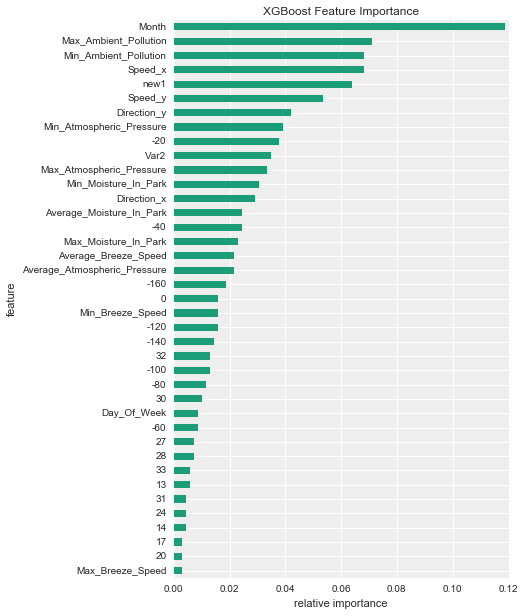

In [496]:
import operator

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

create_feature_map(X_train.columns)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()

In [402]:
colu = [u'Park_ID', 
       u'Average_Breeze_Speed', u'Max_Breeze_Speed', u'Min_Breeze_Speed',
       u'Var2', u'Average_Atmospheric_Pressure', u'Max_Atmospheric_Pressure',
       u'Min_Atmospheric_Pressure', u'Min_Ambient_Pollution',
       u'Max_Ambient_Pollution', u'Average_Moisture_In_Park',
       u'Max_Moisture_In_Park', u'Min_Moisture_In_Park', u'Location_Type',
       u'Year', u'Month', u'Day_Of_Week', 'Week1',
        u'Direction_x', u'Direction_y', u'Speed_x', u'Speed_y', 'Footfall']

The below block contains a small code for tuning xgboost using hyperopt. But always ensure few things before tuning your model that the technique you are using for validation is giving you similar score to your leaderboard score because it is necessary to ensure that your model is learning the exact same thing that you wants it to learn.

In [7]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import xgboost as xgb


def score(params):
    print "Training with params : "
    print params
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    dvalid = xgb.DMatrix(X_test[X_train.columns], label=y_test)
    # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid)
    score = np.sqrt(mean_squared_error(y_test, predictions))
    print "\tScore {0}\n\n".format(score)
    return {'loss': score, 'status': STATUS_OK}


def optimize(trials):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
             'max_depth' : hp.quniform('max_depth', 1, 7, 1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'objective': 'reg:linear',
             'silent' : 0,
            "booster" : "gbtree",
            }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)

    print best

    
to_run = t1.copy()
to_run = to_run[colu]
#to_pred = to_run['Footfall']
#to_run = to_run[colu]

to_add = pd.get_dummies(to_run['Month'])
to_run = pd.concat([to_run, to_add], axis = 1)
to_run.drop('Month', axis=1, inplace=True)

to_add = pd.get_dummies(to_run['Park_ID'])
to_run = pd.concat([to_run, to_add], axis = 1)
to_run.drop('Park_ID', axis=1, inplace=True)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=1234)
X_train = to_run[to_run['Year']<2000]
y_train = to_run['Footfall'][to_run['Year']<2000]

X_test = to_run[to_run['Year'].isin([2001,2000])]
y_test = to_run['Footfall'][to_run['Year'].isin([2001,2000])]

# X_train = to_run
# y_train = to_run['Footfall']

X_train.drop('Year', axis=1, inplace=True)
X_test.drop('Year', axis=1, inplace=True)

X_train.drop('Footfall', axis=1, inplace=True)
X_test.drop('Footfall', axis=1, inplace=True)

#Trials object where the history of search will be stored
trials = Trials()

optimize(trials)

One of the things that we observed after plotting graphs for each park id for each year separately but was not able to implement during the competition, was to use the variation in atmospheric pressure, moisture etc as a feature. After the competition ended we discussed this with few of the experts and they told us that this could have improved our accuracy further. Hence it is recommended to try to use the variations as a feature next time.

The competiotion was great in entirity and a massive learning experience.